In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import seaborn as sns
import imblearn
sns.set_context('poster')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from current_application import get_sql_dataset
from current_application import prepare_dataset

# Cells for EDA directly from SQL database

In [5]:
con = get_sql_dataset.connect_to_sql()

postgresql://nwespe@localhost/mimic


In [6]:
con = psycopg2.connect(database='mimic', user='nwespe', host='localhost')
cur = con.cursor()
cur.execute('SET search_path to mimiciii;') # + schema_name)

In [ ]:
features = pd.read_sql_query('SELECT * from ab_numeric_features;', con)
outcomes = pd.read_sql_query('SELECT * from ab_cdiff_outcomes;', con)

print 'Retrieved data from SQL, have outcomes of length: ' + str(len(outcomes))
print 'Cdiff value counts: ' + str(outcomes.cdiff.value_counts())

In [ ]:
len(set(outcomes.hadm_id.values))

In [ ]:
len(set(features.hadm_id.values))

In [ ]:
features.head()

In [ ]:
outcome_ids = set(outcomes.hadm_id.values)
feature_ids = set(features.hadm_id.values)

In [ ]:
ids_in_both = outcome_ids.intersection(feature_ids)
len(ids_in_both)

In [ ]:
outcomes = outcomes[outcomes.hadm_id.isin(feature_ids)]

In [ ]:
outcomes.cdiff.value_counts()

In [ ]:
multistay_90d = get_sql_dataset.generate_multistay_info(con)

In [ ]:
multistay_90d.head()

In [ ]:
admit_info = pd.read_sql_query('SELECT * FROM all_admit_info;', con)
primary_cdiff_admits = admit_info[admit_info.icd9_code == '00845']  # only include this subset from outcomes list
ids = list(primary_cdiff_admits.hadm_id)
culled_outcomes = outcomes[-outcomes.hadm_id.isin(ids)]

In [ ]:
culled_outcomes.cdiff.value_counts()

In [ ]:
cdiff_outcomes = outcomes[outcomes.cdiff == True]

In [ ]:
len(cdiff_outcomes)

In [ ]:
cdiff_outcome_ids = set(cdiff_outcomes.hadm_id.values)
cdiff_patient_ids = set(cdiff_patients.hadm_id.values)
cdiff_ids_in_both = cdiff_outcome_ids.intersection(cdiff_patient_ids)
len(cdiff_ids_in_both)

In [ ]:
missing_cdiff_ids = cdiff_patient_ids.difference(cdiff_outcome_ids)
len(missing_cdiff_ids)

In [ ]:
cdiff_patients[cdiff_patients.hadm_id.isin(missing_cdiff_ids)]

In [ ]:
outcomes[outcomes.hadm_id.isin(missing_cdiff_ids)]

In [ ]:
all_admit_info[all_admit_info.hadm_id.isin(missing_cdiff_ids)]

In [ ]:
sql_query = """
SELECT *
FROM cdiff_patients;
"""
cdiff_patients = pd.read_sql_query(sql_query, con)  # 

In [ ]:
len(cdiff_patients)

In [ ]:
len(set(cdiff_patients.hadm_id.values))

In [ ]:
cdiff_patients[np.isnan(cdiff_patients.subject_id)] #.head()

In [ ]:
sql_query = """
SELECT *
FROM all_admit_info;
"""
all_admit_info = pd.read_sql_query(sql_query, con)  # 

In [ ]:
len(all_admit_info) #.head()

In [ ]:
def cumulative_class_number(x): # where x is row from df
    # get drug_name tuples from all rows where hadm_id matches and day_prescribed is <= x.day_prescribed
    all_classes = drug_class_per_day[(drug_class_per_day.subject_id == x.subject_id) & 
                                     (drug_class_per_day.hadm_id == x.hadm_id) & 
                                     (drug_class_per_day.day_prescribed <= x.day_prescribed)].drug_class
    all_classes2 = all_classes.apply(pd.Series).stack().tolist()
    unique_drugs = set(all_classes2)
    return len(unique_drugs)


In [ ]:
drug_class_per_day['cumulative_number_classes'] = drug_class_per_day.apply(lambda x: cumulative_class_number(x), axis=1)

In [ ]:
drug_class_per_day.to_csv('/Users/nwespe/Desktop/drug_class_per_day.csv')

In [ ]:
trimmed_scripts = classified_ab_scripts[['subject_id', 'hadm_id', 'day_prescribed', 'drug_name']]

In [ ]:
drugs_per_day = trimmed_scripts.groupby(['subject_id', 'hadm_id', 'day_prescribed'], axis=0).aggregate(lambda x: tuple(x)).reset_index()

In [ ]:
data = drugs_per_day[(drugs_per_day.day_prescribed > 0) & (drugs_per_day.day_prescribed < 11)].day_prescribed
#bins = np.linspace(1, 11, 11)
plt.hist(data, bins=bins)

In [ ]:
def cumulative_number(x): # where x is row from df
    # get drug_name tuples from all rows where hadm_id matches and day_prescribed is <= x.day_prescribed
    all_names = drugs_per_day[(drugs_per_day.subject_id == x.subject_id) & (drugs_per_day.hadm_id == x.hadm_id) & (drugs_per_day.day_prescribed <= x.day_prescribed)].drug_name
    all_names2 = all_names.apply(pd.Series).stack().tolist()
    unique_drugs = set(all_names2)
    return len(unique_drugs)


In [ ]:
drugs_per_day['cumulative_number'] = drugs_per_day.apply(lambda x: cumulative_number(x), axis=1)

In [ ]:
drugs_per_day.to_csv('/Users/nwespe/Desktop/drugs_per_day.csv')

In [ ]:
cumulative_drug_class = drug_class_per_day.drop(['drug_class'], axis=1)
cumulative_drug_class = cumulative_drug_class.groupby(['subject_id', 'hadm_id'])['cumulative_number_classes'].max().reset_index()
cumulative_drug_class.head()

In [ ]:
drugs_outcomes = cumulative_drug_class.merge(both_outcomes, on='hadm_id')

In [ ]:
g = sns.FacetGrid(drugs_outcomes, row="cdiff", col="expire", margin_titles=True, sharey=True)
#bins = np.linspace(0, 24, 12)
g.map(sns.kdeplot, 'cumulative_number', bw=0.5) #, bins=bins, lw=0

In [ ]:
g = sns.FacetGrid(drugs_outcomes, row="cdiff", col="expire", margin_titles=True, sharey=True)
#bins = np.linspace(0, 24, 12)
g.map(sns.kdeplot, 'cumulative_number_classes', bw=0.5) #, bins=bins, lw=0

In [ ]:
sql_query = """
SELECT *
FROM ab_prescriptions;
"""
admit_scripts = pd.read_sql_query(sql_query, con)  # 

In [ ]:
admit_scripts[admit_scripts.subject_id == 54642]

In [ ]:
admit_scripts['admitdate'] = [d.date() for d in admit_scripts['admittime']]
admit_scripts['admitdate'] = admit_scripts['admitdate'].apply(lambda x: datetime64(x))
admit_scripts['time_to_prescription'] = admit_scripts['startdate'] - admit_scripts['admitdate']

In [ ]:
late_event_ids = set(nonprim_cdiff_info[(nonprim_cdiff_info.chart_timelag > 3)].hadm_id.values)
early_event_ids = set(nonprim_cdiff_info[(nonprim_cdiff_info.chart_timelag <= 3)].hadm_id.values)
no_event_ids = set(nonprim_cdiff_info[np.isnan(nonprim_cdiff_info.chart_timelag)].hadm_id.values)

# Cells to prepare dataset for running model

In [164]:
all_features, cdiff_data, outcomes = get_sql_dataset.main()

postgresql://nwespe@localhost/mimic
Retrieved data from SQL, have outcomes of length: 39429
Flag value counts: False    38049
True      1380
Name: cdiff, dtype: int64
Adjusted data values for age, admission time
Removed outliers for height and weight
Log-transformed values for bands, bilirubin, bun, creatinine, glucose, lactate, inr, and wbc
Merged hospital stays within 90 days, now have outcomes: 35268
Flag value counts: False    34016
True      1252
Name: cdiff, dtype: int64
Removed young patients, now have outcomes: 32092
Flag value counts: False    30840
True      1252
Name: cdiff, dtype: int64
Removed admits for cdiff, now have outcomes: 32000
Flag value counts: False    30840
True      1160
Name: cdiff, dtype: int64
Combined features with outcomes, now have data of length: 31331
Columns are: Index([u'hadm_id', u'aniongap', u'albumin', u'bands', u'bicarbonate',
       u'bilirubin', u'creatinine', u'chloride', u'glucose', u'hematocrit',
       u'hemoglobin', u'lactate', u'platelet'

(array([ 1707.,  1285.,  1024.,  3340.,  1465.,  1763.,  2449.,  3025.,
         3585.,  3387.,  3062.,  2498.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.]),
 <a list of 12 Patch objects>)

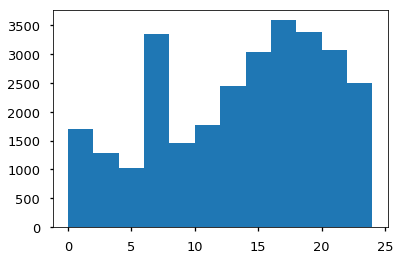

In [208]:
plt.hist(cdiff_data['time_of_admission'], bins=np.linspace(0, 24, 13))

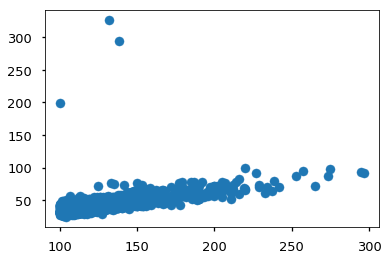

In [241]:
plt.scatter(cdiff_data[cdiff_data.weight > 100].weight.dropna(), cdiff_data[cdiff_data.weight > 100].bmi)

In [ ]:
plt.hist(cdiff_data[cdiff_data.wbc > 100].wbc.dropna())

In [ ]:
from scipy.stats import probplot
fig = plt.figure()
ax = fig.add_subplot(111)
x = cdiff_data.loc[:, 'weight'].dropna()
probplot(x, plot=ax)

In [149]:
bal_data = prepare_dataset.balance_dataset(cdiff_data, 'outcome')

Balanced dataset by undersampling dominant class, now have dataset of length: 2190
Flag value counts: 1    1095
0    1095
Name: outcome, dtype: int64


In [ ]:
get_sql_dataset.plot_feature_counts(cdiff_data)

In [ ]:
get_sql_dataset.plot_probability_quantiles(cdiff_data, save=True)

In [ ]:
get_sql_dataset.plot_features(cdiff_data, save=True)

In [ ]:
get_sql_dataset.plot_correlations(cdiff_data)

# Cells for running a model and evaluating it

In [10]:
from current_application import run_model

In [152]:
# prepare dataset for model
x_train, y_train, test_set = prepare_dataset.main(cdiff_data, only_ab=False, add_ab=False, multioutcome=False)

Selected features and dropped low-feature rows, now have dataset of length: 28590
Flag value counts: 0    27495
1     1095
Name: outcome, dtype: int64
Balanced dataset by undersampling dominant class, now have dataset of length: 2190
Flag value counts: 1    1095
0    1095
Name: outcome, dtype: int64


In [153]:
test_set.head()

,aniongap,albumin,log_bands,bicarbonate,log_bilirubin,log_bun,log_creatinine,chloride,log_glucose,hemoglobin,...,insurance_Self Pay,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,expire,hadm_id,outcome
0,-0.825032,0.594255,1.785953,1.979425,-1.329594,0.107342,-0.011273,0.246321,-0.343739,-0.462122,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,110692.0,1
1,-1.042232,1.501627,-0.266578,0.604571,-0.562668,-0.332801,-0.547951,0.246321,-0.979767,0.566984,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,177580.0,0
2,0.043768,1.350399,-1.269597,0.015348,0.056514,-2.098586,-1.139709,0.538999,-0.748715,0.343265,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,122676.0,0
3,-0.173432,-0.918031,-0.913719,-0.181059,-0.562668,-0.754725,-2.151326,0.392660,-0.823312,-0.641097,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,179236.0,0
4,0.043768,-0.464345,0.621077,0.015348,0.652882,0.920312,-0.128092,-0.631714,-0.262245,0.298521,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,111487.0,1


In [154]:
shape(x_train) #.head()

(1752, 63)

In [155]:
#list(x_train.columns)

In [156]:
x_train.describe()

,aniongap,albumin,log_bands,bicarbonate,log_bilirubin,log_bun,log_creatinine,chloride,log_glucose,hemoglobin,...,insurance_Private,insurance_Self Pay,marital_status_DIVORCED,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,expire,hadm_id
count,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,...,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000
mean,-1.135571e-16,-3.994775e-16,2.068361e-16,2.838926e-17,2.027805e-18,2.484061e-16,-2.737536e-17,7.928716e-16,2.087625e-15,-1.013902e-16,...,0.268265,0.009132,0.063356,0.451484,0.008562,0.265411,0.007420,0.166096,0.122717,150847.302511
std,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,...,0.443183,0.095153,0.243672,0.497783,0.092159,0.441678,0.085844,0.372273,0.328206,29392.413352
min,-2.128231e+00,-3.186461e+00,-1.681117e+00,-3.716397e+00,-2.096521e+00,-3.115178e+00,-3.754702e+00,-6.046265e+00,-4.750324e+00,-3.504696e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100053.000000
25%,-6.078321e-01,-7.668025e-01,-7.622999e-01,-5.738746e-01,-5.626677e-01,-6.600703e-01,-7.198497e-01,-4.853751e-01,-6.763447e-01,-6.858407e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125486.500000
50%,-1.734323e-01,-1.065920e-02,-1.058222e-02,1.534836e-02,-1.140443e-01,-1.278215e-01,-2.550807e-01,9.998175e-02,-1.449216e-01,-1.468473e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150761.000000
75%,4.781674e-01,7.454841e-01,6.507640e-01,6.045713e-01,4.511543e-01,6.837910e-01,4.636667e-01,5.389994e-01,4.896377e-01,6.564712e-01,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,177218.000000
max,8.731763e+00,2.862685e+00,3.006553e+00,4.729132e+00,4.369018e+00,3.311643e+00,4.437408e+00,4.782836e+00,5.008004e+00,4.146482e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,199987.000000


In [157]:
list(x_train.columns)[-5:]

['marital_status_SINGLE',
 'marital_status_UNKNOWN (DEFAULT)',
 'marital_status_WIDOWED',
 'expire',
 'hadm_id']

In [143]:
test_set.to_csv('/Users/nwespe/Desktop/test_set_both_outcome.csv')

In [160]:
curr_model = run_model.fit_model(x_train, y_train, model='RF', save=False)

In [161]:
run_model.evaluate_model(x_train, y_train, curr_model)

Cross validation metrics
CV Scores: [ 0.67840053  0.64586597  0.62335498  0.64142698  0.66975475]
CV Mean: 0.651760642205
CV Standard deviation: 0.0199092180024
Accuracy: 0.588470319635
Classification report: 
             precision    recall  f1-score   support

          0       0.58      0.67      0.62       876
          1       0.61      0.51      0.55       876

avg / total       0.59      0.59      0.59      1752

Confusion matrix results: 
[[588 288]
 [433 443]]
False positives: 288
False negatives: 433


In [146]:
x_test = test_set.drop('outcome', axis=1)
y_test = test_set['outcome'].copy().reset_index(drop=True)

In [147]:
run_model.evaluate_model(x_test, y_test, curr_model)

Cross validation metrics
CV Scores: [ 0.75592895  0.66332496  0.57735027  0.70710678  0.45643546]
CV Mean: 0.632029283811
CV Standard deviation: 0.105631586303
Accuracy: 0.584
Classification report: 
             precision    recall  f1-score   support

          0       0.60      0.68      0.64        31
          1       0.63      0.55      0.59        31
          2       0.57      0.53      0.55        32
          3       0.55      0.58      0.56        31

avg / total       0.59      0.58      0.58       125

Confusion matrix results: 
[[21 10  0  0]
 [14 17  0  0]
 [ 0  0 17 15]
 [ 0  0 13 18]]
False positives: 10
False negatives: 14


In [162]:
prefix='fri_pm_RF'

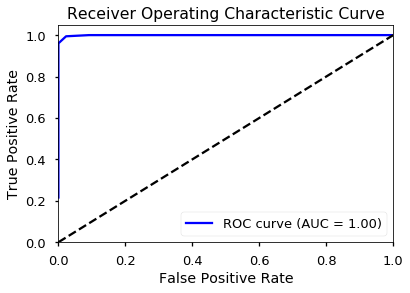

In [163]:
run_model.plot_roc_curve(curr_model, x_train, y_train, save=True, prefix=prefix)

In [96]:
X = x_train
id_col = X.hadm_id
X2 = X.drop('hadm_id', axis=1)
y = y_train
probs = curr_model.predict_proba(X2)
preds = curr_model.predict(X2)
prob_df = pd.DataFrame(y)
prob_df['prob_0'] = probs[:,0]
prob_df['prob_1'] = probs[:,1]
prob_df['predict'] = preds
prob_df = prob_df.join([id_col, X2])

true_pos = prob_df[(prob_df.outcome == 1) & (prob_df.predict == 1)]
true_neg = prob_df[(prob_df.outcome == 0) & (prob_df.predict == 0)]
false_pos = prob_df[(prob_df.outcome == 0) & (prob_df.predict == 1)]
false_neg = prob_df[(prob_df.outcome == 1) & (prob_df.predict == 0)]

In [97]:
prob_df.describe()

,outcome,prob_0,prob_1,predict,hadm_id,aniongap,albumin,log_bands,bicarbonate,log_bilirubin,...,insurance_Medicare,insurance_Private,insurance_Self Pay,marital_status_DIVORCED,marital_status_LIFE PARTNER,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED
count,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,1.752000e+03,...,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000
mean,0.500000,0.500027,0.499973,0.533105,148716.263128,1.784468e-16,5.140485e-16,2.190029e-16,2.027805e-18,-2.838926e-17,...,0.608447,0.275685,0.007991,0.068493,0.000571,0.454338,0.012557,0.234589,0.010845,0.182078
std,0.500143,0.201079,0.201079,0.499045,28892.525562,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,...,0.488237,0.446986,0.089059,0.252662,0.023891,0.498053,0.111384,0.423863,0.103601,0.386019
min,0.000000,0.077026,0.050550,0.000000,100018.000000,-2.376946e+00,-3.135195e+00,-1.679375e+00,-3.656088e+00,-2.056095e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.342478,0.348982,0.000000,123566.500000,-5.814583e-01,-7.729557e-01,-7.593327e-01,-5.772771e-01,-5.467015e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.478350,0.521650,1.000000,148109.500000,-1.325863e-01,-2.964607e-02,-3.725496e-02,0.000000e+00,-1.052321e-01,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.651018,0.657522,1.000000,173150.500000,5.407216e-01,7.467411e-01,7.269219e-01,5.772771e-01,3.963844e-01,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.949450,0.922974,1.000000,199948.000000,5.702749e+00,2.920625e+00,2.957619e+00,4.618216e+00,5.259548e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


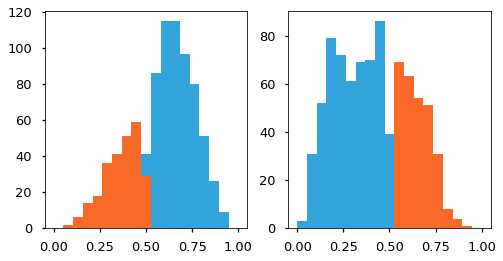

In [98]:
bins = np.linspace(0, 1, 20)
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(list(true_pos.prob_1.values), color='#34A5DA', alpha=1, bins=bins)
ax[0].hist(list(false_neg.prob_1.values), color='#F96928', alpha=1, bins=bins)
ax[1].hist(list(false_pos.prob_1.values), color='#F96928', alpha=1, bins=bins)
ax[1].hist(list(true_neg.prob_1.values), color='#34A5DA', alpha=1, bins=bins)

plt.savefig('/Users/nwespe/Desktop/' + prefix + '_train_probas.svg', bbox_inches='tight')

In [99]:
positives = prob_df[(prob_df.outcome == 1)]
negatives = prob_df[(prob_df.outcome == 0)]
pred_positives = prob_df[(prob_df.predict == 1)]
pred_negatives = prob_df[(prob_df.predict == 0)]

In [100]:
pred_negatives.outcome.value_counts()

0    562
1    256
Name: outcome, dtype: int64

In [104]:
expire = cdiff_data[['hadm_id', 'expire']]

In [133]:
prob_df_expire = prob_df.merge(expire, on='hadm_id', how='left')

In [134]:
prob_df_expire.head()

,outcome,prob_0,prob_1,predict,hadm_id,aniongap,albumin,log_bands,bicarbonate,log_bilirubin,...,insurance_Private,insurance_Self Pay,marital_status_DIVORCED,marital_status_LIFE PARTNER,marital_status_MARRIED,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,expire
0,1,0.404670,0.595330,1,167581,-0.805894,-0.340201,0.612280,1.539405,0.649465,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0,0.630815,0.369185,0,187434,-0.357022,0.746741,1.162579,0.577277,-0.105232,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0,0.698819,0.301181,0,157057,-0.132586,0.436186,-1.679375,0.000000,0.336237,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,0.306271,0.693729,1,143621,-1.479202,-1.427143,-1.679375,0.192426,1.610208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0,0.759391,0.240609,0,157580,-0.357022,1.833683,-0.023762,-0.192426,-0.105232,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


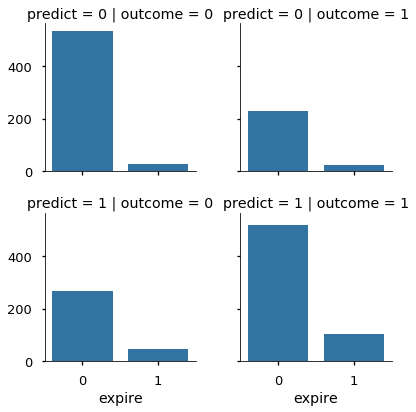

In [135]:
g = sns.FacetGrid(prob_df_expire, col='outcome', row='predict')
g.map(sns.countplot, 'expire')

In [136]:
dataset = prob_df_expire.copy()
dataset['expire'].replace(to_replace=1, value=2, inplace=True)
dataset['outcome'] = dataset['outcome'] + dataset['expire']

In [137]:
dataset.outcome.value_counts()

0    802
1    749
3    127
2     74
Name: outcome, dtype: int64

In [122]:
cols_plot = false_pos.iloc[:, 3:].columns

In [123]:
len(cols_plot)

63

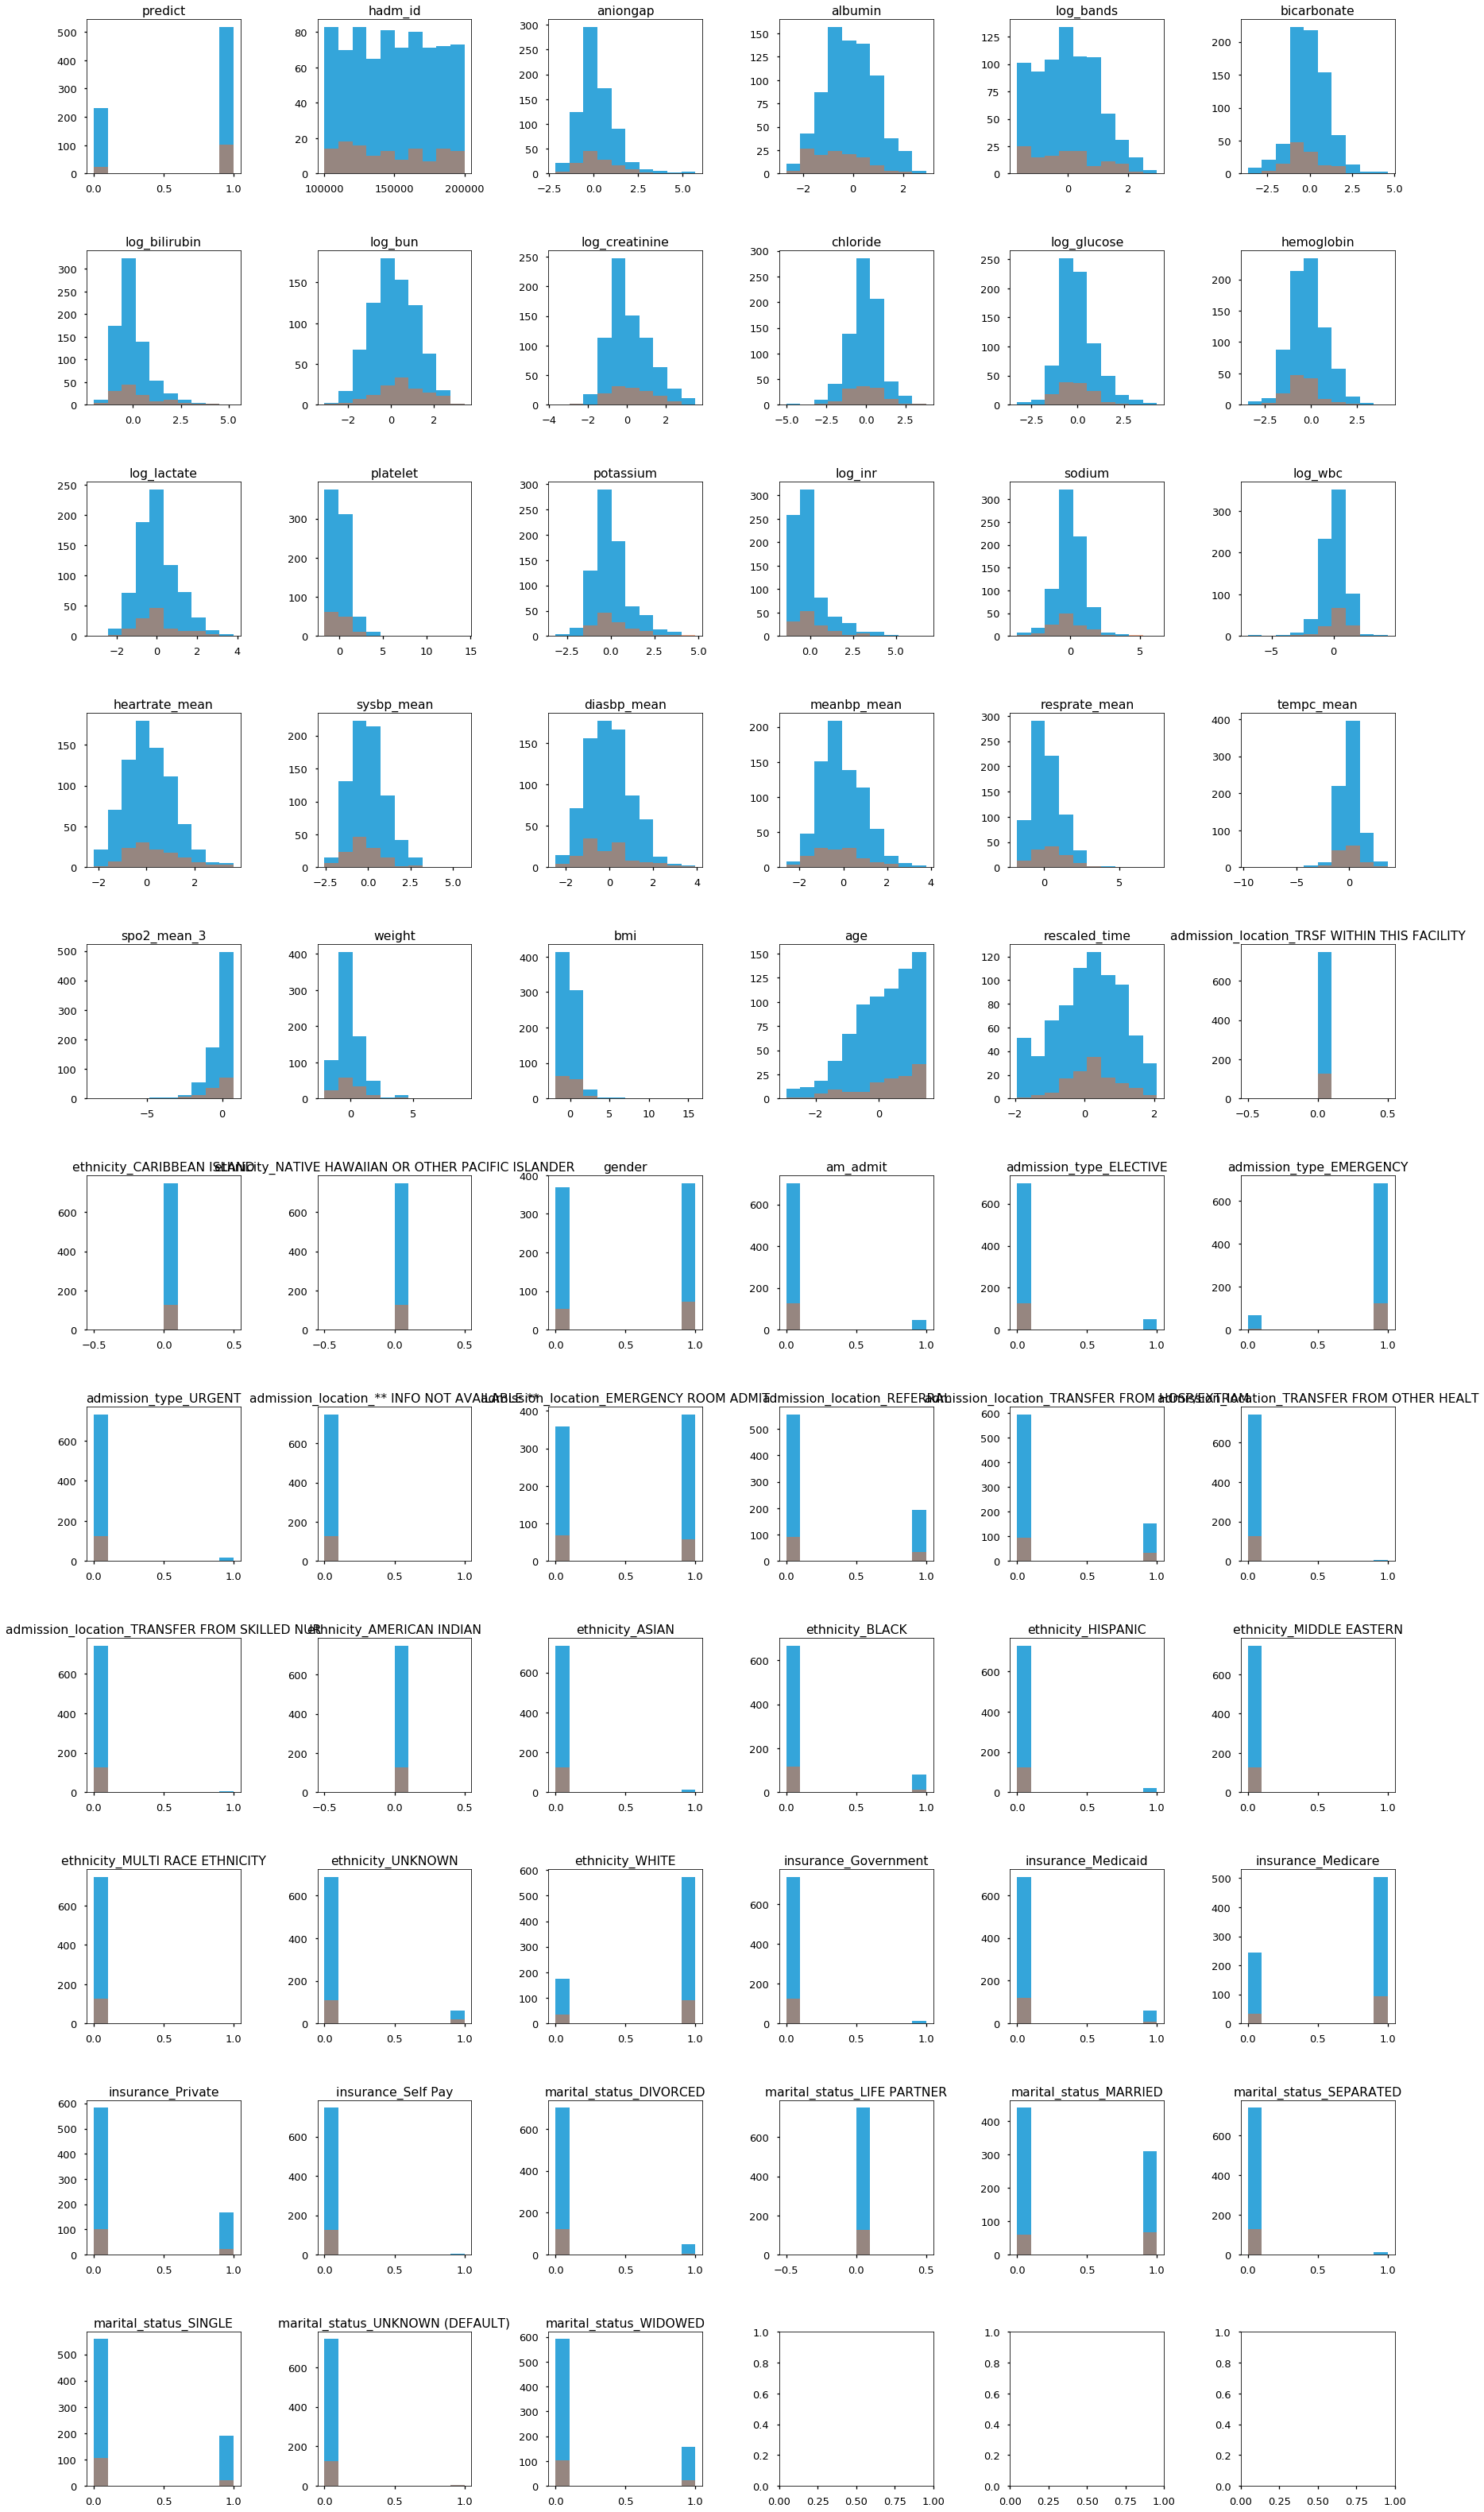

In [124]:
get_sql_dataset.plot_features(prob_df_expire[prob_df_expire.outcome==1], cols=cols_plot, hue='expire', save=False)

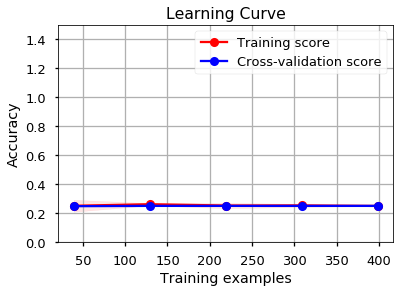

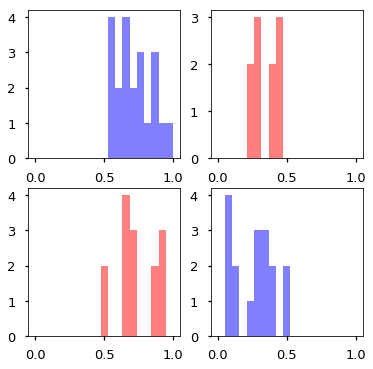

In [150]:
run_model.plot_learning_curve(curr_model, x_train, y_train, save=True, prefix=prefix)
run_model.plot_probas(curr_model, x_test, y_test, save=True, prefix=prefix)

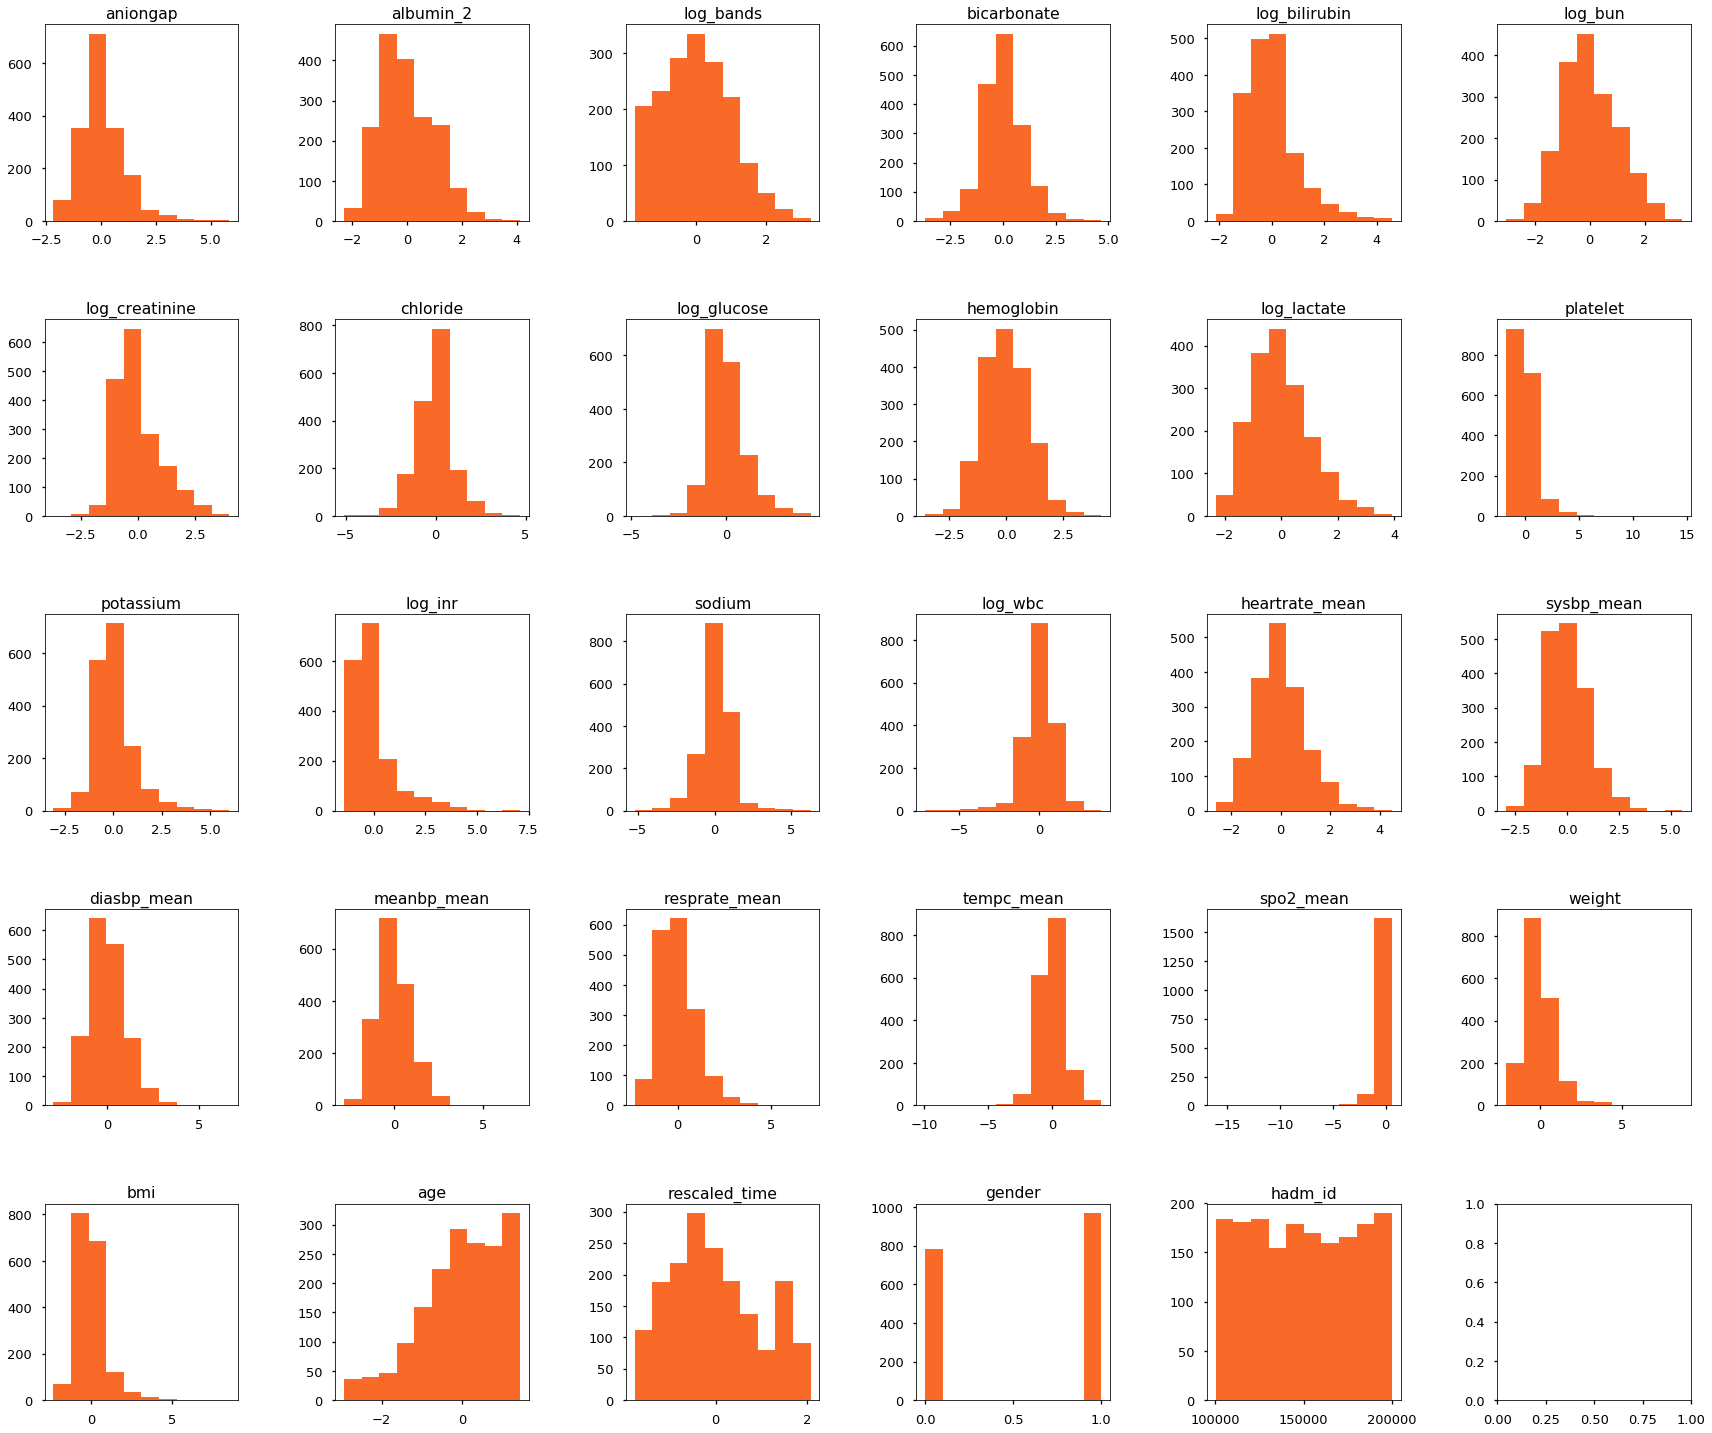

In [153]:
get_sql_dataset.plot_features(x_train, hue=None, save=False)

In [165]:
all_features, cdiff_data, outcomes = get_sql_dataset.main()

postgresql://nwespe@localhost/mimic
Retrieved data from SQL, have outcomes of length: 39429
Flag value counts: False    38049
True      1380
Name: cdiff, dtype: int64
Adjusted data values for age, admission time
Removed outliers for height and weight
Log-transformed values for bands, bilirubin, bun, creatinine, glucose, lactate, inr, and wbc
Merged hospital stays within 90 days, now have outcomes: 35268
Flag value counts: False    34016
True      1252
Name: cdiff, dtype: int64
Removed young patients, now have outcomes: 32092
Flag value counts: False    30840
True      1252
Name: cdiff, dtype: int64
Removed admits for cdiff, now have outcomes: 32000
Flag value counts: False    30840
True      1160
Name: cdiff, dtype: int64
Combined features with outcomes, now have data of length: 31331
Flag value counts: 0    30189
1     1142
Name: outcome, dtype: int64


In [167]:
bal_data = prepare_dataset.balance_dataset(cdiff_data, 'outcome')

Balanced dataset by undersampling dominant class, now have dataset of length: 2284
Flag value counts: 1    1142
0    1142
Name: outcome, dtype: int64


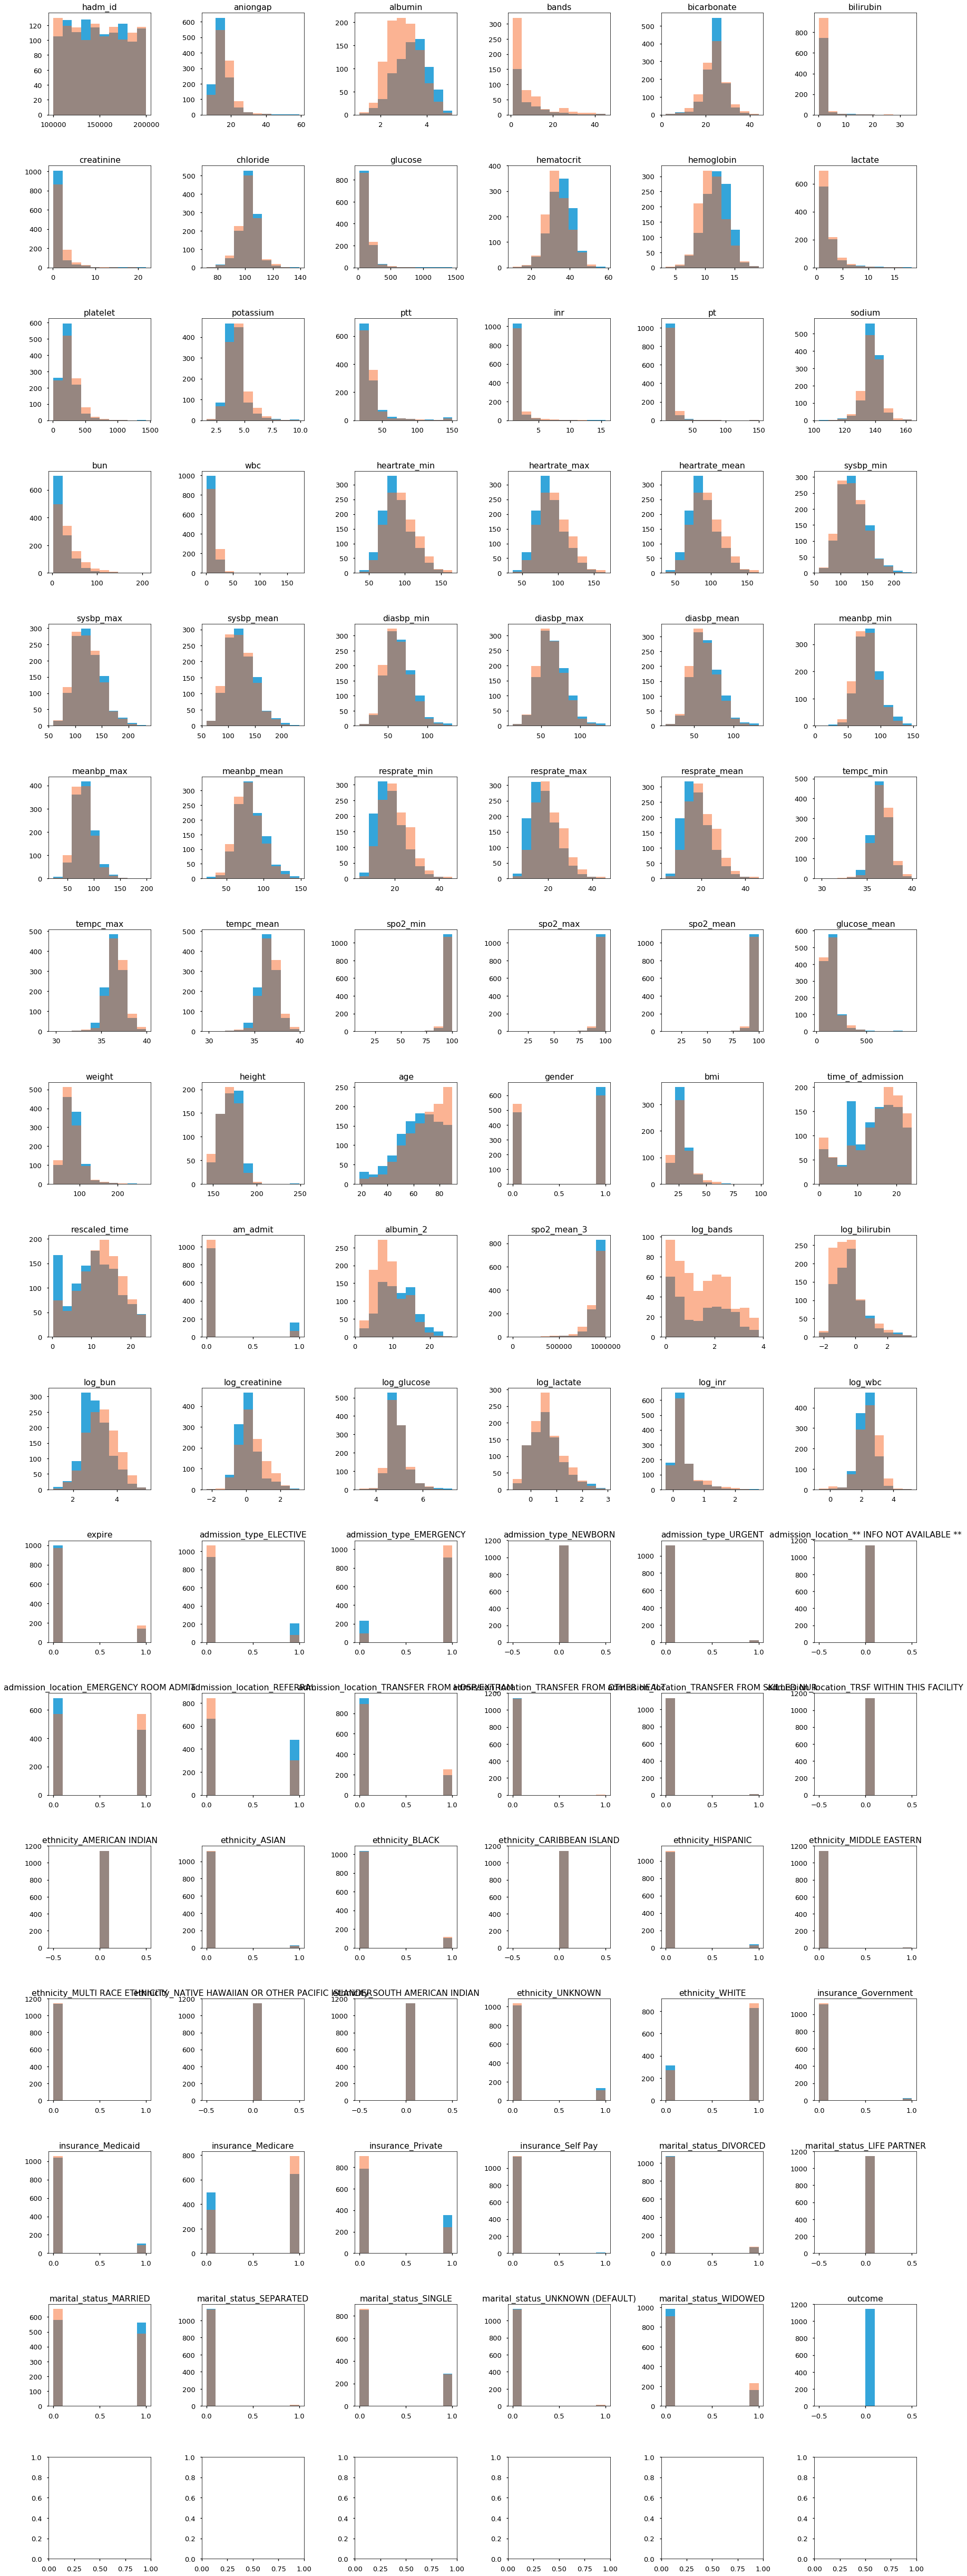

In [168]:
get_sql_dataset.plot_features(bal_data, hue='outcome', save=False)

Optimal number of features : 65


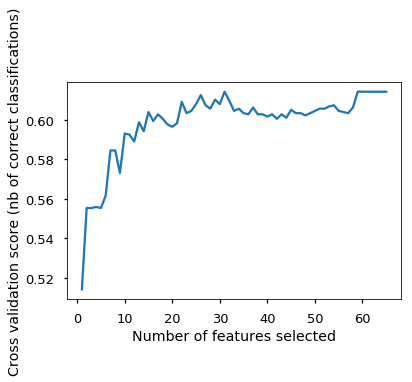

In [351]:
selector = run_model.recursive_feature(x_train, y_train)

In [352]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [264]:
ones = [i for i, v in enumerate(selector.ranking_) if v == 1]
[list(x_train.columns)[i] for i in ones]

['aniongap',
 'albumin',
 'log_creatinine',
 'hemoglobin',
 'heartrate_mean',
 'resprate_mean',
 'tempc_mean',
 'age',
 'am_admit',
 'admission_type_ELECTIVE',
 'admission_type_EMERGENCY',
 'admission_type_URGENT',
 'admission_location_** INFO NOT AVAILABLE **',
 'admission_location_CLINIC REFERRAL/PREMATURE',
 'admission_location_EMERGENCY ROOM ADMIT',
 'admission_location_PHYS REFERRAL/NORMAL DELI',
 'admission_location_TRANSFER FROM OTHER HEALT',
 'admission_location_TRANSFER FROM SKILLED NUR',
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_ASIAN - CAMBODIAN',
 'ethnicity_ASIAN - FILIPINO',
 'ethnicity_ASIAN - THAI',
 'ethnicity_ASIAN - VIETNAMESE',
 'ethnicity_BLACK/CAPE VERDEAN',
 'ethnicity_BLACK/HAITIAN',
 'ethnicity_CARIBBEAN ISLAND',
 'ethnicity_HISPANIC/LATINO - CUBAN',
 'ethnicity_HISPANIC/LATINO - PUERTO RICAN',
 'ethnicity_HISPANIC/LATINO - SALVADORAN',
 'ethnicity_MIDDLE EASTERN',
 'ethnicity_MULTI RACE ETHNICITY',
 'ethnicity_PATIENT DECLINED

In [ ]:
onetofour = [i for i, v in enumerate(selector.ranking_) if v < 5]
[list(x_train.columns)[i] for i in onetofour]

# Cells for feature importance and selection

In [354]:
X = x_train.drop('hadm_id', axis=1)
coefs = np.around(curr_model.coef_, 3)
coefs.reshape(-1)
std = X.std(axis=0)
std_coef_series = pd.Series(np.reshape(np.array(std)*coefs, -1), index=std.index)
feature_importance_df = pd.DataFrame(data=[std, std_coef_series])
model_feature_importance = feature_importance_df.loc[1].sort_values()

In [355]:
model_feature_importance

albumin                                        -0.361103
hemoglobin                                     -0.185053
admission_location_PHYS REFERRAL/NORMAL DELI   -0.168969
am_admit                                       -0.163294
admission_type_ELECTIVE                        -0.145241
meanbp_mean                                    -0.124035
admission_location_CLINIC REFERRAL/PREMATURE   -0.120522
potassium                                      -0.100029
log_lactate                                    -0.094027
log_glucose                                    -0.093027
admission_location_TRANSFER FROM HOSP/EXTRAM   -0.090750
admission_location_EMERGENCY ROOM ADMIT        -0.085193
rescaled_time                                  -0.068019
marital_status_WIDOWED                         -0.059663
weight                                         -0.051015
platelet                                       -0.048014
diasbp_mean                                    -0.042012
ethnicity_ASIAN                

In [ ]:
model_feature_importance.to_csv('/Users/nwespe/Desktop/wed_feature_importance.csv')

In [ ]:
y_test.iloc[661]

In [ ]:
X_df = pd.DataFrame(X, columns=test_df.columns)
profile = X_df.sample(n=1)

In [ ]:
profile = np.around(profile, decimals=1)

In [ ]:
profile.transpose()

In [ ]:
test_df.head()

In [ ]:
#result = run_model.eval_risk()

In [ ]:
check_data = X_df.iloc[:20]
check_outcomes = y_train.iloc[:20]
predictions = log_reg.predict(check_data)
#check_data_prepared = num_pipeline.transform(check_data)
print "Predictions:" + str(predictions)

In [ ]:
print log_reg.coef_

In [ ]:
log_mse = mean_squared_error(check_outcomes, predictions)
log_rmse = np.sqrt(log_mse)

In [ ]:
log_rmse

In [ ]:
check_outcomes.values

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_df, y_train)

In [ ]:
check_data = X_df.iloc[:20]
check_outcomes = y_train.iloc[:20]
predictions = tree_reg.predict(check_data)
#check_data_prepared = num_pipeline.transform(check_data)
print "Predictions:" + str(predictions)

In [ ]:
tree_mse = mean_squared_error(check_outcomes, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(tree_reg, X_df, y_train, scoring='neg_mean_squared_error', cv=10)

In [ ]:
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print 'Scores:' + str(scores)
    print 'Mean:' + str(scores.mean())
    print 'Standard deviation:' + str(scores.std())

In [ ]:
display_scores(tree_rmse_scores)

In [ ]:
scores = cross_val_score(log_reg, X_df, y_train, scoring='neg_mean_squared_error', cv=10)
log_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(log_rmse_scores)

In [ ]:
missing_mask = np.ma.getmaskarray(np.ma.masked_invalid(x_train))
knn_mse = ((X_filled_knn[missing_mask] - np.array(X_df)[missing_mask]) ** 2).mean()
print("knnImpute MSE: %f" % knn_mse)

In [ ]:
sql_query = """
SELECT c.*
FROM chartevents c
WHERE c.hadm_id = 170249
AND c.itemid IN (226512, 226531);  
"""
see_items = pd.read_sql_query(sql_query, con)
see_items 
#LIKE '%icarb%'

In [ ]:
sql_query = """
SELECT dl.itemid, dl.label, dl.fluid, dl.category
FROM d_labitems dl
WHERE dl.itemid IN (50803, 50804, 50882);  
"""
see_items = pd.read_sql_query(sql_query,con)
see_items 

In [ ]:
sql_query = """
SELECT pr.drug, pr.drug_type, pr.drug_name_poe, pr.drug_name_generic
FROM prescriptions pr
WHERE pr.drug LIKE '%cin';
"""
see_drugs = pd.read_sql_query(sql_query,con)
unique(see_drugs.drug)

In [ ]:
sql_query = """
SELECT * FROM diagnoses_icd;
"""
diagnoses = pd.read_sql_query(sql_query,con)

# need to get set of subject_id's associated with one or more icd codes whose 
# first 3 digits are lower than 140
# first remove rows with codes starting with V or E

diagnoses['icd9_letter'] = diagnoses.icd9_code.str[0]
diagnoses = diagnoses[(diagnoses.icd9_letter != 'E') & (diagnoses.icd9_letter != 'V')]
diagnoses['icd9_3digit'] = diagnoses.icd9_code.str[:3]
diagnoses.icd9_3digit = pd.to_numeric(diagnoses.icd9_3digit)
diagnoses.head()

In [ ]:
sql_query = """
CREATE VIEW infection_admissions AS 
SELECT * FROM admissions
WHERE hadm_id IN %s;"""
hadm_ids = tuple(infected_admits)

cur.execute(sql_query, (hadm_ids,))

In [ ]:
infection_admissions = pd.read_sql_query('SELECT * FROM infection_admissions',con)
infection_admissions.head()

In [ ]:
print infection_admissions.hospital_expire_flag.value_counts()
print infection_admissions.admission_location.value_counts()

In [ ]:
subset['chartlag'] = (subset.charttime - subset.admittime) / np.timedelta64(1, 'h')

In [ ]:
early_charts = subset[subset.chartlag < 3]
early_charts.head()

In [ ]:
sql_query = """
SELECT ia.hadm_id, ia.subject_id, ia.admittime, pr.icustay_id, pr.startdate, 
ia.hospital_expire_flag, pr.drug
FROM infection_admissions ia
LEFT JOIN prescriptions pr ON ia.hadm_id = pr.hadm_id
WHERE pr.drug_type = 'MAIN';"""

prescriptions = pd.read_sql_query(sql_query, con)

In [ ]:
patients['age_at_death'] = (patients.dod - patients.dob)/np.timedelta64(1, 'Y')

In [ ]:
age_bins = [-300, 0, 18, 40, 50, 60 ,70, 80, 90, 100]
age_labels = ['exclude', 'youth', '18-39', '40-49', '50-59', '60-69', '70-79', '80-89', '>89']
age_categories = pd.cut(patients['age_at_death'], age_bins, labels=age_labels)
patients['age_category'] = pd.cut(patients['age_at_death'], age_bins, labels=age_labels)

In [ ]:
outcome = 'hospital_expire_flag'
feature = 'age_category'
db = infect_pts

g = sns.countplot(x=outcome, hue=feature, data=db)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Patient outcomes and age at death')
#plt.savefig('/Users/nwespe/Desktop/pt_expire_ethnicity.png', bbox_inches='tight')